Alicia Sadler , Meryem Bouziani, Efua Yankson 

# Part 1: Data Collection for Text Comparison and Clustering

## Data Collection

In [97]:
#Importing all the libraries needed

import wikipedia
import requests
from bs4 import BeautifulSoup
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON
from urllib.parse import quote
from typing import List, Dict, Tuple
import requests
import json
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import collections
from collections import Counter
from collections import defaultdict
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import spacy
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from collections import Counter
import requests
from bs4 import BeautifulSoup
import os
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.utils import shuffle
from tqdm import tqdm
import stanza
import re
import ast
import warnings



nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/asadl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/asadl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Categories for our Biographies
 - Astronauts
 - Chefs

# PART 1: Comparing and Clustering Text
# I.1 Data Collection


In [2]:
# Defining categories and setting limit for number of biographies to be extacted
categories = [("Astronauts", "dbo:Astronaut"), ("Chefs", "dbo:Chef")]
max_biographies_per_category = 100
max_biographies = 100
output_dir =  "output"  #This is the name of the file where the corpus will be saved



 **Extracting Biographies**

In [3]:
def get_biography_from_wikipedia(wiki_url: str) -> str:
    """
    Retrieves the introductory biography text from a given Wikipedia page.

    Args:
        wiki_url (str): The URL of the Wikipedia page.

    Returns:
        str: The introductory biography text, or an empty string if retrieval fails.
    """
    try:
        response = requests.get(wiki_url)
        response.raise_for_status()  # Raise HTTPError for bad responses
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, "html.parser")
            intro_paragraphs = soup.find_all('p', limit=3)
            intro_text = " ".join([para.text.strip() for para in intro_paragraphs])
            return intro_text
    except requests.RequestException as e:
        pass
    except Exception as e:
        pass
    return ""

In [4]:

def get_biographies_en(category: str, rdf_type: str, max_biographies: int) -> List[Dict[str, str]]:
    """
    Retrieves biographies from Wikipedia for a given category using SPARQL.

    Args:
        category (str): The category name (e.g., "Astronauts", "Chefs").
        rdf_type (str): The RDF type for the category (e.g., "dbo:Astronaut").
        max_biographies (int): Maximum number of biographies to retrieve.

    Returns:
        List[Dict[str, str]]: A list of dictionaries with 'name' and 'biography' keys.
    """
    biographies = []
    unique_names = set()

    sparql = SPARQLWrapper("https://dbpedia.org/sparql")
    offset = 0
    while len(biographies) < max_biographies:
        query = f"""
            PREFIX dbo: <http://dbpedia.org/ontology/>
            PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

            SELECT DISTINCT ?page ?name
            WHERE {{
                ?page rdf:type {rdf_type} .
                ?page rdfs:label ?name .
                FILTER (lang(?name) = 'en')
            }}
            LIMIT {max_biographies}
            OFFSET {offset}
        """

        sparql.setQuery(query)
        sparql.setReturnFormat(JSON)

        try:
            results = sparql.query().convert()
            if not results["results"]["bindings"]:
                break

            for result in results["results"]["bindings"]:
                if len(biographies) >= max_biographies:
                    break

                name = result["name"]["value"]
                if name in unique_names:
                    continue
                unique_names.add(name)

                dbpedia_url = result["page"]["value"]
                wiki_title = dbpedia_url.split("/")[-1]
                wiki_url = f"https://en.wikipedia.org/wiki/{wiki_title}"

                intro_text = get_biography_from_wikipedia(wiki_url)

                if intro_text:
                    biographies.append({"name": name, "biography": intro_text})

        except Exception:
            break

        offset += max_biographies  # Move to the next batch

    return biographies[:max_biographies]  # Return only up to max_biographies




In [5]:
astronaut_biographies = get_biographies_en("Astronauts", "dbo:Astronaut", 100)
chef_biographies = get_biographies_en("Chefs", "dbo:Chef", 100)


print(f"Astronaut biographies: {len(astronaut_biographies)}")
print(f"Chef biographies: {len(chef_biographies)}")

Astronaut biographies: 100
Chef biographies: 100


In [6]:
print(astronaut_biographies)
print(chef_biographies)

[{'name': 'Cai Xuzhe', 'biography': " Cai Xuzhe (Chinese: 蔡旭哲; born May 1976)[2] is a Chinese People's Liberation Army Astronaut Corps (PLAAC) taikonaut selected as part of the Shenzhou program. Cai was born in Shenzhou, Hengshui, Hebei province in 1976.[2] His grandparents come from a scholarly family, teaching in the downtown county and village, respectively, and were veteran party members before the founding of the People's Republic of China.[3]  His third uncle was a soldier.[3] Cai graduated from the Baoding Branch of the Changchun Flight Academy of the Air Force.[3]  He served as a fighter pilot in the People's Liberation Army Air Force, and was subsequently selected to be an astronaut in 2010.[4] His name was revealed as part of Group 2 in 2011.[5]"}, {'name': 'Carl E. Walz', 'biography': " Carl Erwin Walz (born 6 September 1955) is a retired NASA astronaut currently working for Orbital Sciences Corporation's Advanced Programs Group as vice president for Human Space Flight Opera

**Extracting Knowledge Graph Facts**

In [7]:
def extract_kg_facts(person_names: List[str]) -> Dict[str, List[Dict]]:
    """
    Extract KG Graph facts (RDF triples) for the specified people from DBpedia.

    Args:
        person_names (List[str]): List of person names.

    Returns:
        Dict[str, List[Dict]]: A dictionary containing KG Graph facts for each person.
    """
    kg_facts = {}

    for person_name in person_names:
        kg_facts[person_name] = []

        sparql = SPARQLWrapper("http://dbpedia.org/sparql")
        encoded_person_name = quote(person_name.replace(" ", "_"))
        query = f"""
            PREFIX dbo: <http://dbpedia.org/ontology/>
            PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
            SELECT DISTINCT ?predicate ?object
            WHERE {{
                <http://dbpedia.org/resource/{encoded_person_name}> ?predicate ?object.
            }}
        """

        sparql.setQuery(query)
        sparql.setReturnFormat(JSON)

        results = sparql.query().convert()

        for result in results["results"]["bindings"]:
            predicate = result["predicate"]["value"]
            obj = result["object"]["value"]
            kg_facts[person_name].append({"predicate": predicate, "object": obj})

    return kg_facts



   **Storing Data**
   - Each biography will also be saved in a separate text file named **`person_category.txt`**.
   - The knowledge graph facts will be stored in a JSON file, mapped back to each person.

In [8]:
def save_biographies_and_facts(data: Dict[str, Dict[str, List[Dict]]], output_dir: str) -> None:
    """
    Save biographies and KG facts to text files and JSON file respectively.

    Args:
        data (Dict[str, Dict[str, List[Dict]]]): A dictionary containing biographies and KG facts for each category.
        output_dir (str): Directory to save the output files.

    Returns:
        None
    """
    os.makedirs(output_dir, exist_ok=True)

    for category, category_data in data.items():
        biographies = category_data["biographies"]
        kg_facts = category_data["kg_facts"]

        # Save biographies to text files
        for bio in biographies:
            person_name = bio["name"]
            biography_text = bio["biography"]
            # Generate safe file name
            safe_person_name = "".join([c if c.isalnum() else "_" for c in person_name])
            safe_person_name = safe_person_name[:50]  # Truncate if longer than 50 characters
            filename = f"{safe_person_name}_{category}.txt"

            with open(os.path.join(output_dir, filename), 'w', encoding='utf-8') as f:
                f.write(biography_text)

        # Save KG facts to JSON
        kg_facts_path = os.path.join(output_dir, f"{category}_kg_facts.json")
        with open(kg_facts_path, 'w', encoding='utf-8') as f:
            json.dump(kg_facts, f, indent=4, ensure_ascii=False)

    print("Biographies and KG facts saved successfully.")

In [9]:
categories = [
    ("Astronauts", "dbo:Astronaut"),
    ("Chefs", "dbo:Chef")
    ]

max_biographies = 100
output_dir = "./output"

biographies_data = {}
for category, rdf_type in categories:
    biographies = get_biographies_en(category, rdf_type, max_biographies)
    kg_facts = extract_kg_facts([bio["name"] for bio in biographies])
    biographies_data[category] = {"biographies": biographies, "kg_facts": kg_facts}

save_biographies_and_facts(biographies_data, output_dir)

Biographies and KG facts saved successfully.


**Bibliographies will be stored as a dataframe**

In [10]:
# Define the clean_name function
def clean_name(name: str) -> str:
    """
    Clean the person's name by removing any text within parentheses.
    
    Args:
        name (str): The original name string.
    
    Returns:
        str: The cleaned name string.
    """
    # Use regex to remove any text within parentheses
    cleaned_name = re.sub(r'\s*\(.*?\)', '', name)
    return cleaned_name.strip()

In [11]:
def store_biographies_as_dataframe(biographies_data: Dict[str, Dict[str, List[Dict[str, str]]]]) -> pd.DataFrame:
    """
    Store each biography along with its category and person's name in a Pandas DataFrame.

    Args:
        biographies_data (Dict[str, Dict[str, List[Dict[str, str]]]]): A dictionary containing biographies and KG facts for each category.

    Returns:
        pd.DataFrame: DataFrame containing biographies, categories, and person names.
    """
    biographies_list = []
    categories_list = []
    person_names_list = []

    for category, data in biographies_data.items():
        biographies = data["biographies"]
        for bio in biographies:
            biographies_list.append(bio["biography"])
            categories_list.append(category)
            cleaned_name = clean_name(bio["name"])
            person_names_list.append(cleaned_name)

    df = pd.DataFrame({"Biography": biographies_list, "Category": categories_list, "Person_Name": person_names_list})
    return df

In [12]:
#  store biographies in a DataFrame
df_english = store_biographies_as_dataframe(biographies_data)

In [13]:
df_english

,Biography,Category,Person_Name
0,Cai Xuzhe (Chinese: 蔡旭哲; born May 1976)[2] is...,Astronauts,Cai Xuzhe
1,Carl Erwin Walz (born 6 September 1955) is a ...,Astronauts,Carl E. Walz
2,"Carl Joseph Meade (born November 16, 1950) is ...",Astronauts,Carl J. Meade
3,Carlos Ismael Noriega (born 8 October 1959) i...,Astronauts,Carlos I. Noriega
4,Pyotr Valerievich Dubrov (Russian: Пётр Валерь...,Astronauts,Pyotr Dubrov
...,...,...,...
195,"Juliet Corson (January 14, 1841 – June 18, 18...",Chefs,Juliet Corson
196,Beverly Kim is a James Beard Award-winning che...,Chefs,Beverly Kim
197,"Patrick O'Connell (born October 9, 1945) is an...",Chefs,Patrick O'Connell
198,Paul Ainsworth (born 1979) is an English chef...,Chefs,Paul Ainsworth


## I.2 Data Analysis: Text Data


### Preprocessing Function (`preprocess_text`):
1. Normalize each sentence to lowercase.
2. Remove stopwords .
3. Join the remaining tokens back into sentences.

In [14]:
nlp = spacy.load("en_core_web_sm")

In [15]:
df_english

,Biography,Category,Person_Name
0,Cai Xuzhe (Chinese: 蔡旭哲; born May 1976)[2] is...,Astronauts,Cai Xuzhe
1,Carl Erwin Walz (born 6 September 1955) is a ...,Astronauts,Carl E. Walz
2,"Carl Joseph Meade (born November 16, 1950) is ...",Astronauts,Carl J. Meade
3,Carlos Ismael Noriega (born 8 October 1959) i...,Astronauts,Carlos I. Noriega
4,Pyotr Valerievich Dubrov (Russian: Пётр Валерь...,Astronauts,Pyotr Dubrov
...,...,...,...
195,"Juliet Corson (January 14, 1841 – June 18, 18...",Chefs,Juliet Corson
196,Beverly Kim is a James Beard Award-winning che...,Chefs,Beverly Kim
197,"Patrick O'Connell (born October 9, 1945) is an...",Chefs,Patrick O'Connell
198,Paul Ainsworth (born 1979) is an English chef...,Chefs,Paul Ainsworth


In [16]:

biographies_df = df_english


def preprocess_text(text):
      """
    Tokenizes and segments a given text into sentences.

    Args:
        text (str): The input text to be processed.

    Returns:
        List[str]: A list of sentences extracted from the input text.
    """
    doc = nlp(text)  # Tokenize
    sentences = [sent.text for sent in doc.sents]  # Segment into sentences
    return sentences


biographies_df['preprocessed_sentences'] = biographies_df['Biography'].apply(preprocess_text)

def preprocess_tokens(text):
    doc = nlp(text.lower())  # Tokenize and normalize to lowercase
    # Remove stopwords, punctuation, and non-alphabetic tokens
    preprocessed_text = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.is_alpha]
    return preprocessed_text

biographies_df['preprocessed_text'] = biographies_df['Biography'].apply(preprocess_tokens)

In [17]:
biographies_df.head()

,Biography,Category,Person_Name,preprocessed_sentences,preprocessed_text
0,Cai Xuzhe (Chinese: 蔡旭哲; born May 1976)[2] is...,Astronauts,Cai Xuzhe,[ Cai Xuzhe (Chinese: 蔡旭哲; born May 1976)[2] i...,"[cai, xuzhe, chinese, 蔡旭哲, bear, chinese, peop..."
1,Carl Erwin Walz (born 6 September 1955) is a ...,Astronauts,Carl E. Walz,[ Carl Erwin Walz (born 6 September 1955) is a...,"[carl, erwin, walz, bear, september, retire, n..."
2,"Carl Joseph Meade (born November 16, 1950) is ...",Astronauts,Carl J. Meade,"[Carl Joseph Meade (born November 16, 1950) is...","[carl, joseph, meade, bear, november, nasa, as..."
3,Carlos Ismael Noriega (born 8 October 1959) i...,Astronauts,Carlos I. Noriega,[ Carlos Ismael Noriega (born 8 October 1959) ...,"[carlos, ismael, noriega, bear, october, peruv..."
4,Pyotr Valerievich Dubrov (Russian: Пётр Валерь...,Astronauts,Pyotr Dubrov,[Pyotr Valerievich Dubrov (Russian: Пётр Валер...,"[pyotr, valerievich, dubrov, russian, пётр, ва..."


In [18]:
def get_all_tokens(df, category):
    """
    Extracts and returns all tokens from a specified category in the DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing tokenized text data.
        category (str): The category of text to filter by.

    Returns:
        List[str]: A list of all tokens from the specified category.
    """
    tokens = []
    for series in df[df["Category"] == category]['preprocessed_text']:
        for t in series:
            tokens.append(t)
    return tokens

In [19]:
CATEGORY1 = 'Astronauts'
CATEGORY2 = 'Chefs'

In [20]:
tokens1 = get_all_tokens(biographies_df, CATEGORY1)
tokens2 = get_all_tokens(biographies_df, CATEGORY2)

- Vocabulary: 50 most frequent words and word cloud for each category.

In [21]:

def make_wordcloud(tokens, n_words):
    """
    Generates and displays a word cloud from a list of tokens.

    Args:
        tokens (List[str]): The list of tokens to be used for the word cloud.
        n_words (int): The number of most common words to include in the word cloud.

    Returns:
        None: The function displays the word cloud plot.
    """
    data = collections.Counter(tokens).most_common(n_words)
    word_frequencies = {word: freq for word, freq in data}

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

- wordcloud for the category : 'Astronauts'

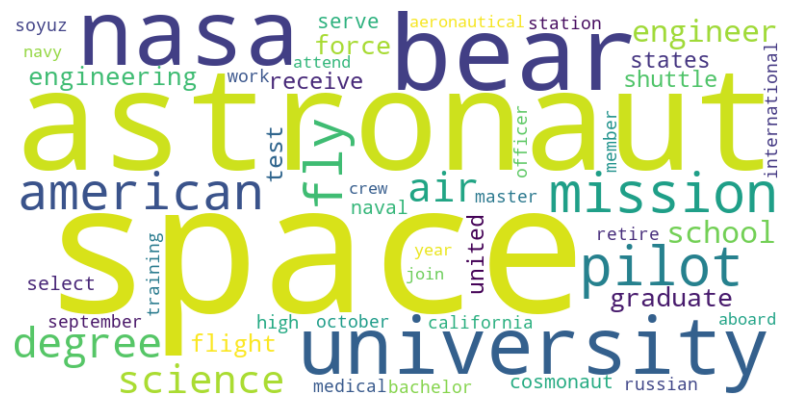

In [22]:
make_wordcloud(tokens1, 50)

- wordcloud for the category : 'Chefs'

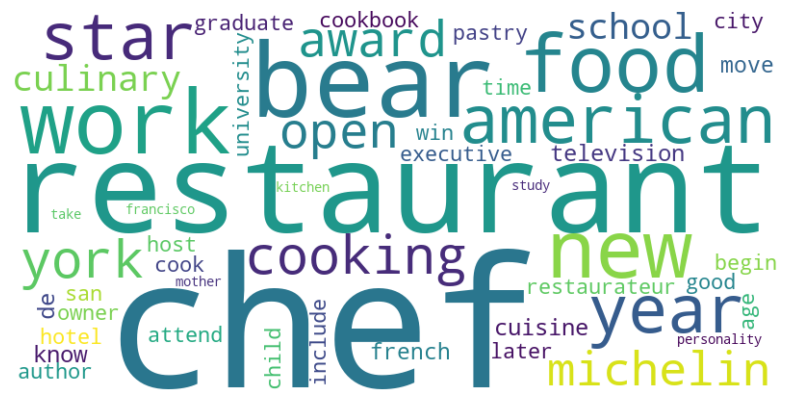

In [23]:
make_wordcloud(tokens2, 50)

In [24]:
biographies_df['num_sentences'] = biographies_df['preprocessed_sentences'].apply(len)

In [25]:
biographies_df

,Biography,Category,Person_Name,preprocessed_sentences,preprocessed_text,num_sentences
0,Cai Xuzhe (Chinese: 蔡旭哲; born May 1976)[2] is...,Astronauts,Cai Xuzhe,[ Cai Xuzhe (Chinese: 蔡旭哲; born May 1976)[2] i...,"[cai, xuzhe, chinese, 蔡旭哲, bear, chinese, peop...",5
1,Carl Erwin Walz (born 6 September 1955) is a ...,Astronauts,Carl E. Walz,[ Carl Erwin Walz (born 6 September 1955) is a...,"[carl, erwin, walz, bear, september, retire, n...",6
2,"Carl Joseph Meade (born November 16, 1950) is ...",Astronauts,Carl J. Meade,"[Carl Joseph Meade (born November 16, 1950) is...","[carl, joseph, meade, bear, november, nasa, as...",10
3,Carlos Ismael Noriega (born 8 October 1959) i...,Astronauts,Carlos I. Noriega,[ Carlos Ismael Noriega (born 8 October 1959) ...,"[carlos, ismael, noriega, bear, october, peruv...",10
4,Pyotr Valerievich Dubrov (Russian: Пётр Валерь...,Astronauts,Pyotr Dubrov,[Pyotr Valerievich Dubrov (Russian: Пётр Валер...,"[pyotr, valerievich, dubrov, russian, пётр, ва...",6
...,...,...,...,...,...,...
195,"Juliet Corson (January 14, 1841 – June 18, 18...",Chefs,Juliet Corson,"[ Juliet Corson (January 14, 1841 – June 18, 1...","[juliet, corson, january, june, leader, cooker...",5
196,Beverly Kim is a James Beard Award-winning che...,Chefs,Beverly Kim,[Beverly Kim is a James Beard Award-winning ch...,"[beverly, kim, james, beard, award, win, chef,...",5
197,"Patrick O'Connell (born October 9, 1945) is an...",Chefs,Patrick O'Connell,"[Patrick O'Connell (born October 9, 1945) is a...","[patrick, bear, october, american, chef, propr...",2
198,Paul Ainsworth (born 1979) is an English chef...,Chefs,Paul Ainsworth,[ Paul Ainsworth (born 1979) is an English che...,"[paul, ainsworth, bear, english, chef, southam...",7


- sum of sentences in each category

In [26]:
biographies_df.groupby('Category')['num_sentences'].sum()

Category
Astronauts    649
Chefs         718
Name: num_sentences, dtype: int64

- Min/max/avg number of sentences per each category

In [27]:
min_sentences = biographies_df.groupby('Category')['num_sentences'].min()
avg_sentences = biographies_df.groupby('Category')['num_sentences'].mean()
max_sentences = biographies_df.groupby('Category')['num_sentences'].max()

print("Minimum Number of Sentences per Category:\n", min_sentences)
print("\nAverage Number of Sentences per Category:\n", avg_sentences)
print("\nMaximum Number of Sentences per Category:\n", max_sentences)


Minimum Number of Sentences per Category:
 Category
Astronauts    1
Chefs         1
Name: num_sentences, dtype: int64

Average Number of Sentences per Category:
 Category
Astronauts    6.49
Chefs         7.18
Name: num_sentences, dtype: float64

Maximum Number of Sentences per Category:
 Category
Astronauts    19
Chefs         17
Name: num_sentences, dtype: int64


- Box plots & Histograms for both categories

/Users/asadl/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/asadl/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


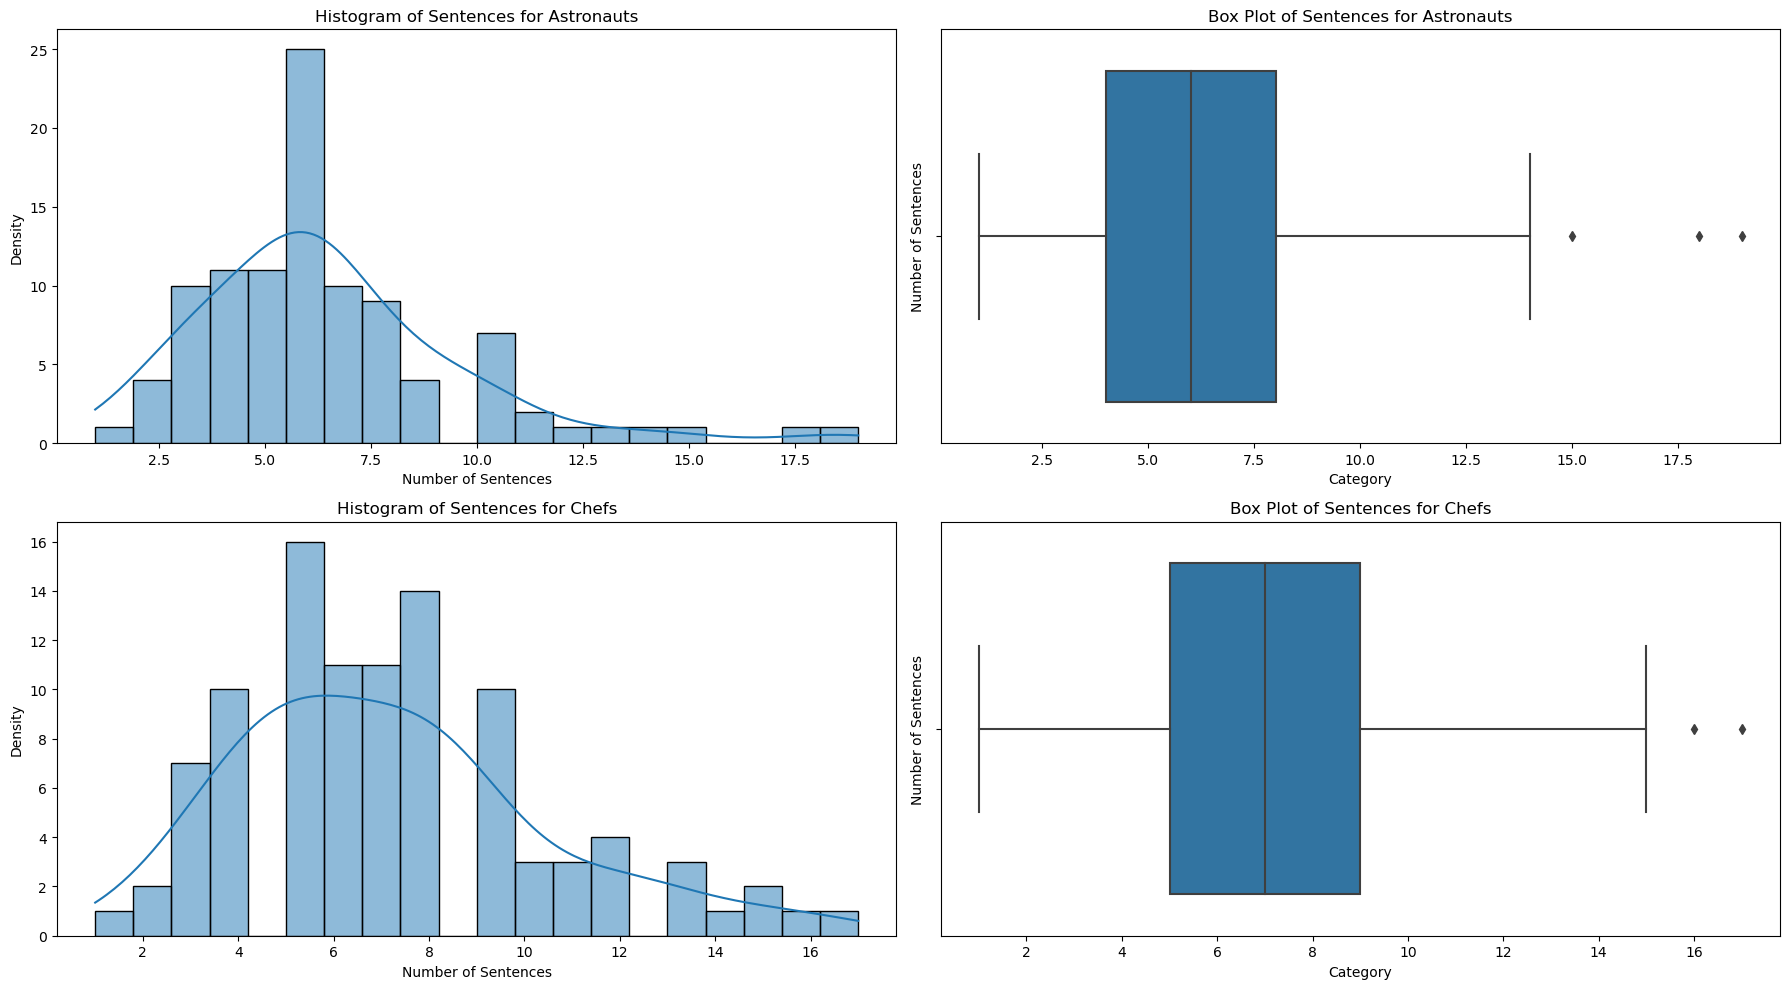

In [28]:

def plot_sentences_stats(biographies_df):
    """
    Generate histograms and box plots for the number of sentences per category.

    Input:
    - biographies_df (DataFrame): DataFrame containing biographical data with 'Category' and 'num_sentences' columns.

    Output:
    - None
    """
    categories = biographies_df['Category'].unique()


    data = []
    for category in categories:
        num_sentences = biographies_df[biographies_df['Category'] == category]['num_sentences']
        for sentence_count in num_sentences:
            data.append({'Category': category, 'Number of Sentences': sentence_count})

    df = pd.DataFrame(data)


    fig, axes = plt.subplots(nrows=len(categories), ncols=2, figsize=(18, 10))

    for i, category in enumerate(categories):
        # Histogram
        sns.histplot(data=df[df['Category'] == category], x='Number of Sentences', bins=20, ax=axes[i, 0], kde=True)
        axes[i, 0].set_title(f'Histogram of Sentences for {category}')
        axes[i, 0].set_xlabel('Number of Sentences')
        axes[i, 0].set_ylabel('Density')

        # Box plot
        sns.boxplot(data=df[df['Category'] == category], x='Number of Sentences', ax=axes[i, 1])
        axes[i, 1].set_title(f'Box Plot of Sentences for {category}')
        axes[i, 1].set_xlabel('Category')
        axes[i, 1].set_ylabel('Number of Sentences')

    plt.tight_layout()
    plt.show()






plot_sentences_stats(biographies_df)

In [29]:
def collect_bigrams(tokens):
    bigrams = nltk.bigrams(tokens)
    occurences = {}
    for bigram in bigrams:
        if occurences.get(bigram):
            occurences[bigram] += 1
        else:
            occurences[bigram] = 1
    return occurences

In [30]:
bigrams1 = collect_bigrams(tokens1)
bigrams2 = collect_bigrams(tokens2)

In [31]:
biographies_df['bi_grams'] = biographies_df['preprocessed_text'].apply(lambda x: list(nltk.bigrams(x)))

# Count occurrences of each bigram
bi_gram_counts = biographies_df['bi_grams'].apply(Counter)

print(bi_gram_counts)

0      {('cai', 'xuzhe'): 1, ('xuzhe', 'chinese'): 1,...
1      {('carl', 'erwin'): 1, ('erwin', 'walz'): 1, (...
2      {('carl', 'joseph'): 1, ('joseph', 'meade'): 1...
3      {('carlos', 'ismael'): 1, ('ismael', 'noriega'...
4      {('pyotr', 'valerievich'): 1, ('valerievich', ...
                             ...                        
195    {('juliet', 'corson'): 1, ('corson', 'january'...
196    {('beverly', 'kim'): 1, ('kim', 'james'): 1, (...
197    {('patrick', 'bear'): 1, ('bear', 'october'): ...
198    {('paul', 'ainsworth'): 2, ('ainsworth', 'bear...
199    {('paul', 'bartolotta'): 2, ('bartolotta', 'be...
Name: bi_grams, Length: 200, dtype: object


In [32]:
bi_gram_counts

0      {('cai', 'xuzhe'): 1, ('xuzhe', 'chinese'): 1,...
1      {('carl', 'erwin'): 1, ('erwin', 'walz'): 1, (...
2      {('carl', 'joseph'): 1, ('joseph', 'meade'): 1...
3      {('carlos', 'ismael'): 1, ('ismael', 'noriega'...
4      {('pyotr', 'valerievich'): 1, ('valerievich', ...
                             ...                        
195    {('juliet', 'corson'): 1, ('corson', 'january'...
196    {('beverly', 'kim'): 1, ('kim', 'james'): 1, (...
197    {('patrick', 'bear'): 1, ('bear', 'october'): ...
198    {('paul', 'ainsworth'): 2, ('ainsworth', 'bear...
199    {('paul', 'bartolotta'): 2, ('bartolotta', 'be...
Name: bi_grams, Length: 200, dtype: object

- min/max/avg number of bi-gram occurrences per sentence per category.

In [33]:
min_per_category = biographies_df.groupby('Category')['bi_grams'].apply(lambda x: np.min([len(bi_gram) for bi_gram in x]))
max_per_category = biographies_df.groupby('Category')['bi_grams'].apply(lambda x: np.max([len(bi_gram) for bi_gram in x]))
avg_per_category = biographies_df.groupby('Category')['bi_grams'].apply(lambda x: np.mean([len(bi_gram) for bi_gram in x]))

print("\nMin number of bi-gram occurrences per sentence per category:")
print(min_per_category)

print("\nMax number of bi-gram occurrences per sentence per category:")
print(max_per_category)

print("\nAverage number of bi-gram occurrences per sentence per category:")
print(avg_per_category)



Min number of bi-gram occurrences per sentence per category:
Category
Astronauts    13
Chefs         27
Name: bi_grams, dtype: int64

Max number of bi-gram occurrences per sentence per category:
Category
Astronauts    202
Chefs         200
Name: bi_grams, dtype: int64

Average number of bi-gram occurrences per sentence per category:
Category
Astronauts    69.77
Chefs         76.33
Name: bi_grams, dtype: float64


In [34]:
def compute_top_properties(kg_facts):
    """
    Computes and returns the top properties in a list of knowledge graph (KG) facts.

    Args:
        kg_facts (List[Dict]): A list of dictionaries representing KG facts, each containing a 'property' key.

    Returns:
        List[Tuple[str, int]]: A sorted list of tuples where each tuple contains a property and its count, 
                               ordered by count in descending order.
    """

    property_counts = {}

    for fact in kg_facts:
        property = fact['property']  # Assuming each fact has a 'property' key

        if property in property_counts:
            property_counts[property] += 1
        else:
            property_counts[property] = 1

    # Convert dictionary to sorted list of tuples
    sorted_properties = sorted(property_counts.items(), key=lambda x: x[1], reverse=True)
    return sorted_properties


In [35]:
exclusions = [
    "http://dbpedia.org/ontology/wikiPageExternalLink",
    "http://dbpedia.org/ontology/wikiPageRevisionID",
    "http://dbpedia.org/ontology/wikiPageWikiLink",
    "http://dbpedia.org/property/wikiPageUsesTemplate",
    "http://www.w3.org/1999/02/22-rdf-syntax-ns#type",
    "http://www.w3.org/2000/01/rdf-schema#label",
    "http://www.w3.org/2000/01/rdf-schema#comment",
    "http://dbpedia.org/ontology/wikiPageLength",
    "http://dbpedia.org/ontology/wikiPageID",
    "http://xmlns.com/foaf/0.1/isPrimaryTopicOf",
    "http://www.w3.org/ns/prov#wasDerivedFrom"
]


In [36]:

def format_property_name(uri, max_length=30):
    """
    Formats a URI into a more readable property name and truncates if necessary.

    Input:
    - uri (str): The URI to be formatted.
    - max_length (int): Maximum length to truncate the property name.

    Output:
    - str: The formatted and possibly truncated property name.
    """
    name = uri.split('/')[-1]
    name = name.split('#')[-1]
    name = name.replace('_', ' ')

    # Perform replacements for readability
    replacements = {
        'PageID': 'Page ID',
        'URL': 'URL',
        'birthDate': 'Birth Date',
        'deathDate': 'Death Date',
        'birthPlace': 'Birth Place',
        'deathPlace': 'Death Place',
        'sameAs': 'Same As'
    }
    for key, value in replacements.items():
        name = name.replace(key, value)

    # Truncate name if it exceeds max_length
    if len(name) > max_length:
        name = name[:max_length] + '...'

    return name


In [37]:
def compute_top_properties(kg_facts, exclusions):
    """
    Computes the top properties from the knowledge graph facts, excluding specified properties.

    Input:
    - kg_facts (dict): The knowledge graph facts.
    - exclusions (list): List of properties to exclude.

    Output:
    - list: Top 50 properties with their counts.
    """
    all_properties = []
    for person, facts in kg_facts.items():
        properties = [fact['predicate'] for fact in facts if fact['predicate'] not in exclusions]
        all_properties.extend(properties)

    # Count occurrences of each property
    property_counts = Counter(all_properties)

    # top 50 properties
    top_properties = property_counts.most_common(50)

    return top_properties

Top 50 RDF Properties for Category: Astronauts
Property: Same As, Count: 2423
Property: subject, Count: 1379
Property: abstract, Count: 1120
Property: depiction, Count: 513
Property: mission, Count: 199
Property: Birth Place, Count: 131
Property: type, Count: 129
Property: mission, Count: 125
Property: occupation, Count: 122
Property: Birth Place, Count: 118
Property: occupation, Count: 118
Property: name, Count: 116
Property: almaMater, Count: 104
Property: almaMater, Count: 101
Property: thumbnail, Count: 87
Property: Birth Date, Count: 86
Property: Birth Date, Count: 86
Property: name, Count: 83
Property: selection, Count: 81
Property: selection, Count: 81
Property: rank, Count: 74
Property: nationality, Count: 73
Property: insignia, Count: 69
Property: wordnet type, Count: 69
Property: hypernym, Count: 68
Property: time, Count: 53
Property: status, Count: 52
Property: status, Count: 52
Property: missions, Count: 41
Property: Same As, Count: 39
Property: awards, Count: 31
Property: 

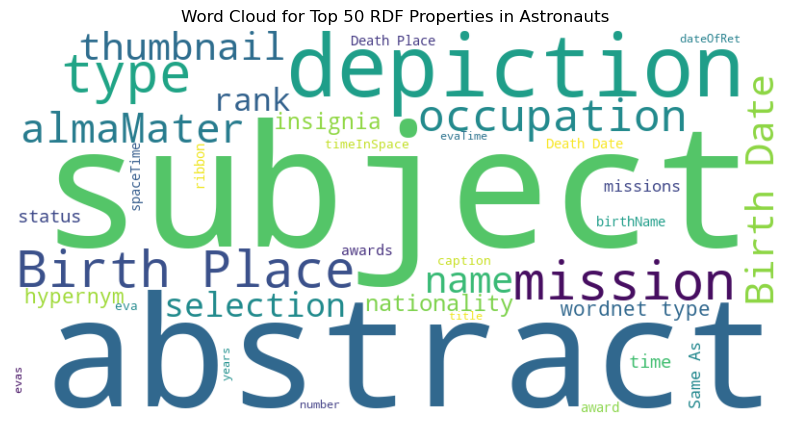

Top 50 RDF Properties for Category: Chefs
Property: subject, Count: 776
Property: Same As, Count: 616
Property: abstract, Count: 209
Property: restaurants, Count: 135
Property: television, Count: 113
Property: Birth Place, Count: 99
Property: Birth Place, Count: 94
Property: name, Count: 80
Property: name, Count: 79
Property: depiction, Count: 65
Property: spouse, Count: 61
Property: hypernym, Count: 61
Property: prevrests, Count: 60
Property: Birth Date, Count: 58
Property: education, Count: 55
Property: style, Count: 53
Property: Birth Date, Count: 52
Property: thumbnail, Count: 45
Property: ratings, Count: 43
Property: Same As, Count: 43
Property: awards, Count: 42
Property: caption, Count: 37
Property: homepage, Count: 33
Property: website, Count: 27
Property: birthName, Count: 26
Property: birthName, Count: 25
Property: award, Count: 22
Property: Death Date, Count: 11
Property: children, Count: 11
Property: Death Date, Count: 10
Property: spouse, Count: 9
Property: Death Place, Co

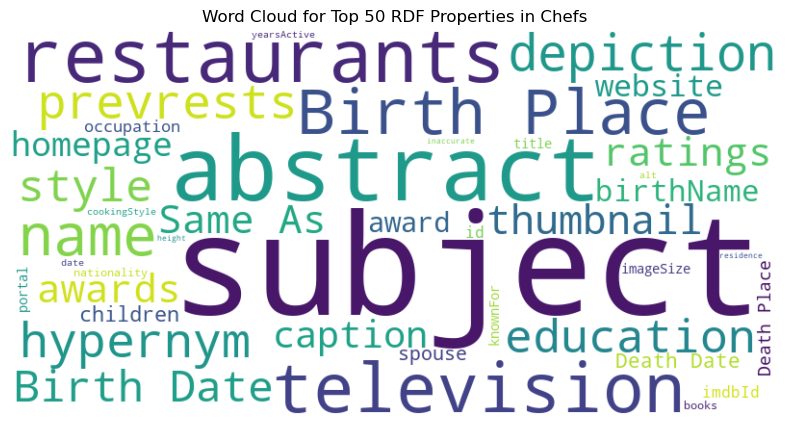

In [38]:
def generate_wordcloud(top_properties, category):
    """
    Generates a word cloud from the top properties.

    Input:
    - top_properties (list): Top properties with their counts.
    - category (str): Category name for the title.

    Output:
    - None
    """
    wordcloud_dict = {format_property_name(prop): count for prop, count in top_properties}

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_dict)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Top 50 RDF Properties in {category}')
    plt.show()


for category, data in biographies_data.items():
    kg_facts = data['kg_facts']
    top_properties = compute_top_properties(kg_facts, exclusions)  # Pass exclusions list

    print(f"Top 50 RDF Properties for Category: {category}")
    for prop, count in top_properties:
        print(f"Property: {format_property_name(prop)}, Count: {count}")
    print("\n")

    generate_wordcloud(top_properties, category)

In [39]:
def plot_facts_stats(stats):
    """
    Generate histograms and box plots for the number of facts per category.

    Input:
    - stats (dict): Dictionary containing statistics for each category.

    Output:
    - None
    """

    data = []
    for category, category_stats in stats.items():
        for num_facts in category_stats['num_facts']:
            data.append({'Category': category, 'Number of Facts': num_facts})

    df = pd.DataFrame(data)


    categories = df['Category'].unique()
    fig, axes = plt.subplots(nrows=len(categories), ncols=2, figsize=(18, 8))

    for i, category in enumerate(categories):
        # Histogram
        sns.histplot(data=df[df['Category'] == category], x='Number of Facts', bins=30, ax=axes[i, 0], kde=True)
        axes[i, 0].set_title(f'Histogram of Number of Facts for {category}')
        axes[i, 0].set_xlabel('Number of Facts')
        axes[i, 0].set_ylabel('Density')

        # Boxplot
        sns.boxplot(data=df[df['Category'] == category], x='Number of Facts', ax=axes[i, 1])
        axes[i, 1].set_title(f'Boxplot of Number of Facts for {category}')
        axes[i, 1].set_xlabel('Category')
        axes[i, 1].set_ylabel('Number of Facts')

    plt.tight_layout()
    plt.show()

In [40]:
def compute_facts_stats(biographies_data):
    """
    Computes statistical information about knowledge graph facts for each category.

    Args:
        biographies_data (Dict[str, Dict[str, List[Dict]]]): A dictionary containing biographies 
            and knowledge graph facts for each category. Each category maps to another dictionary 
            where 'kg_facts' is a key mapping to a dictionary of persons and their associated facts.

    Returns:
        Dict[str, Dict[str, Union[int, float, List[int]]]]: A dictionary with categories as keys, 
            each mapping to another dictionary containing statistics about the number of facts per person.
            The statistics include the total number of facts, minimum, maximum, and average number of facts.
    """
    facts_stats = {}
    for category, data in biographies_data.items():
        num_facts = [len(data['kg_facts'][person]) for person in data['kg_facts']]
        stats = {
            'num_facts': num_facts,
            'min': min(num_facts),
            'max': max(num_facts),
            'avg': sum(num_facts) / len(num_facts)
        }
        facts_stats[category] = stats
    return facts_stats

/Users/asadl/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/asadl/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


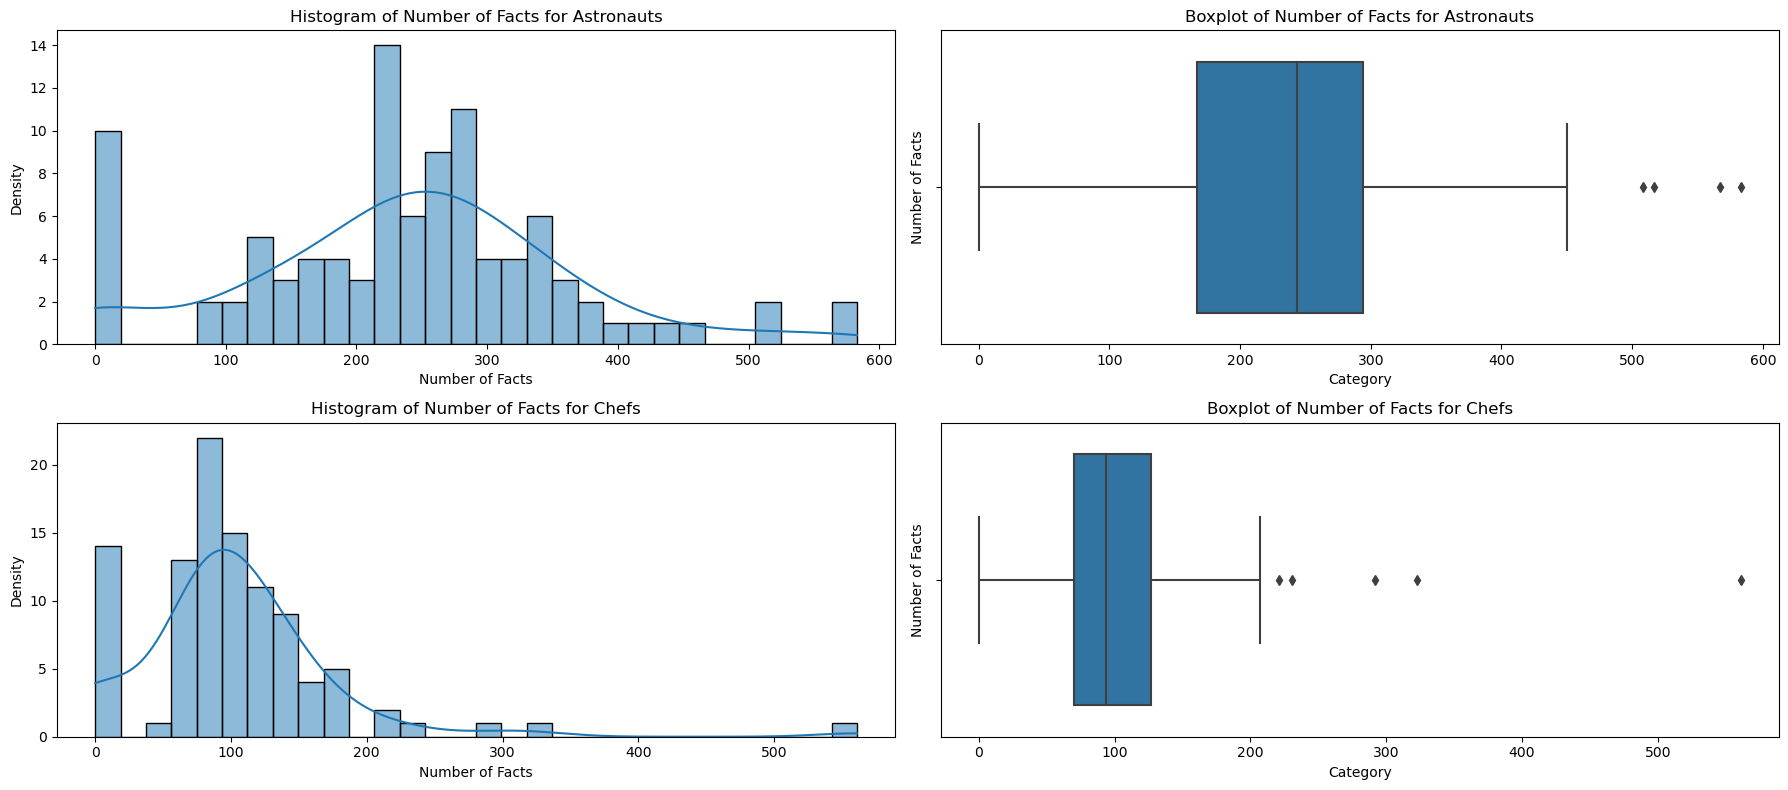

In [41]:
facts_stats = compute_facts_stats(biographies_data)


plot_facts_stats(facts_stats)


# `I.3: Clustering`

## Clustering based on text

In [42]:
df_shuffled = biographies_df.sample(frac=1).reset_index(drop=True)

df_shuffled.head()


,Biography,Category,Person_Name,preprocessed_sentences,preprocessed_text,num_sentences,bi_grams
0,"Paul Bartolotta (born June 8, 1961) is an Amer...",Chefs,Paul Bartolotta,"[Paul Bartolotta (born June 8, 1961) is an Ame...","[paul, bartolotta, bear, june, american, chef,...",16,"[(paul, bartolotta), (bartolotta, bear), (bear..."
1,"Saransh Goila (born February 17, 1987) is an I...",Chefs,Saransh Goila,"[Saransh Goila (born February 17, 1987) is an ...","[saransh, goila, bear, february, indian, winne...",11,"[(saransh, goila), (goila, bear), (bear, febru..."
2,"Carla Hall (born May 12, 1964)[1] is an Americ...",Chefs,Carla Hall,"[Carla Hall (born May 12, 1964)[1] is an Ameri...","[carla, hall, bear, american, chef, television...",5,"[(carla, hall), (hall, bear), (bear, american)..."
3,David Saint-Jacques OC OQ FRCGS[2] (Quebec Fr...,Astronauts,David Saint-Jacques,[ David Saint-Jacques OC OQ FRCGS[2] (Quebec F...,"[david, saint, jacque, oc, oq, quebec, french,...",4,"[(david, saint), (saint, jacque), (jacque, oc)..."
4,"Roy Choi (born February 24, 1970)[1] is a Kor...",Chefs,Roy Choi,"[ Roy Choi (born February 24, 1970)[1] is a Ko...","[roy, choi, bear, february, korean, american, ...",6,"[(roy, choi), (choi, bear), (bear, february), ..."


In [43]:
category_mapping = { "Astronauts": 0, "Chefs" : 1}

#applying to df
df_shuffled['numerical_category'] = df_shuffled['Category'].map(category_mapping)
df_shuffled.head()

,Biography,Category,Person_Name,preprocessed_sentences,preprocessed_text,num_sentences,bi_grams,numerical_category
0,"Paul Bartolotta (born June 8, 1961) is an Amer...",Chefs,Paul Bartolotta,"[Paul Bartolotta (born June 8, 1961) is an Ame...","[paul, bartolotta, bear, june, american, chef,...",16,"[(paul, bartolotta), (bartolotta, bear), (bear...",1
1,"Saransh Goila (born February 17, 1987) is an I...",Chefs,Saransh Goila,"[Saransh Goila (born February 17, 1987) is an ...","[saransh, goila, bear, february, indian, winne...",11,"[(saransh, goila), (goila, bear), (bear, febru...",1
2,"Carla Hall (born May 12, 1964)[1] is an Americ...",Chefs,Carla Hall,"[Carla Hall (born May 12, 1964)[1] is an Ameri...","[carla, hall, bear, american, chef, television...",5,"[(carla, hall), (hall, bear), (bear, american)...",1
3,David Saint-Jacques OC OQ FRCGS[2] (Quebec Fr...,Astronauts,David Saint-Jacques,[ David Saint-Jacques OC OQ FRCGS[2] (Quebec F...,"[david, saint, jacque, oc, oq, quebec, french,...",4,"[(david, saint), (saint, jacque), (jacque, oc)...",0
4,"Roy Choi (born February 24, 1970)[1] is a Kor...",Chefs,Roy Choi,"[ Roy Choi (born February 24, 1970)[1] is a Ko...","[roy, choi, bear, february, korean, american, ...",6,"[(roy, choi), (choi, bear), (bear, february), ...",1


In [44]:

X = df_shuffled['preprocessed_text']
Y = df_shuffled['numerical_category']
X

0      [paul, bartolotta, bear, june, american, chef,...
1      [saransh, goila, bear, february, indian, winne...
2      [carla, hall, bear, american, chef, television...
3      [david, saint, jacque, oc, oq, quebec, french,...
4      [roy, choi, bear, february, korean, american, ...
                             ...                        
195    [william, dean, fear, bear, american, chef, kn...
196    [scott, douglas, scooter, altman, bear, august...
197    [samantha, cristoforetti, omri, italian, pronu...
198    [brigadier, roberto, vittori, omri, bear, octo...
199    [carlos, ismael, noriega, bear, october, peruv...
Name: preprocessed_text, Length: 200, dtype: object

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [46]:
# Convert each list of tokens into a single string document
X_train = X_train.apply(lambda x: ' '.join(x))
X_test = X_test.apply(lambda x: ' '.join(x))

In [47]:
#vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=500, use_idf=True, stop_words='english')
X_train_vectors = tfidf_vectorizer.fit_transform(X_train)
X_test_vectors = tfidf_vectorizer.transform(X_test)

In [48]:
#  reducing dimentionality
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_vectors.toarray())
X_test_pca = pca.transform(X_test_vectors.toarray())

In [49]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(X_train_vectors)

KMeans(n_clusters=2, n_init=10, random_state=0)

In [50]:
train_predicted_labels = kmeans.labels_
test_predicted_labels = kmeans.predict(X_test_vectors)

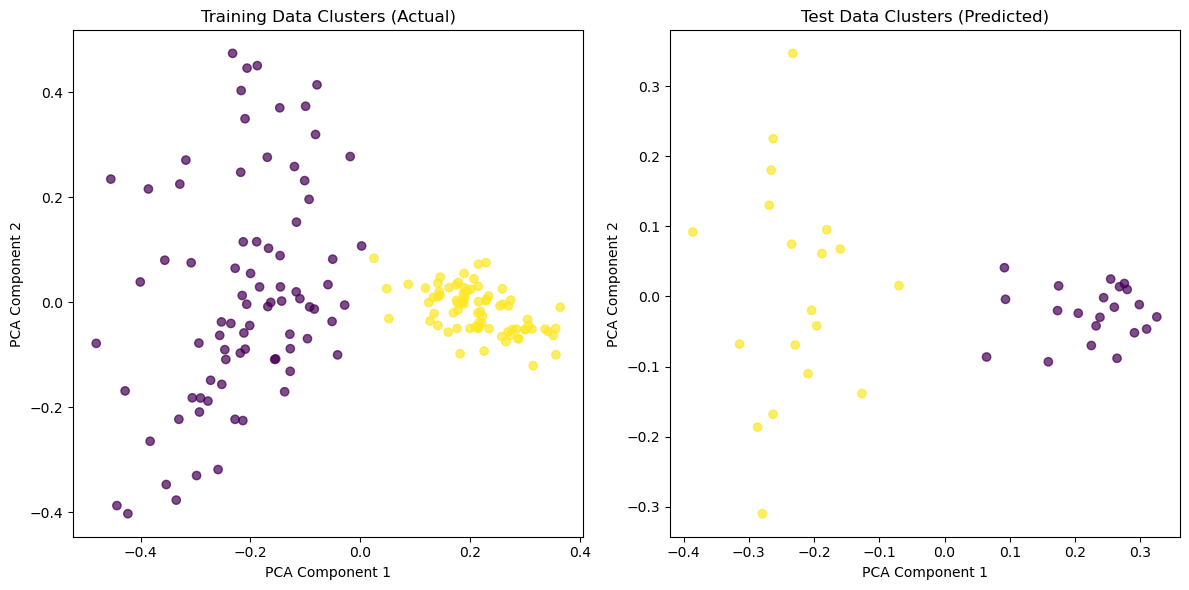

In [51]:
#plotting the figures

plt.figure(figsize=(12, 6))

# Training data clusters
plt.subplot(1, 2, 1)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', alpha=0.7)
plt.title('Training Data Clusters (Actual)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# Test data clusters
plt.subplot(1, 2, 2)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=test_predicted_labels, cmap='viridis', alpha=0.7)
plt.title('Test Data Clusters (Predicted)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.tight_layout()
plt.show()

In [52]:
print("Training Set Metrics:")
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_train, train_predicted_labels))
print("Completeness: %0.3f" % metrics.completeness_score(y_train, train_predicted_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y_train, train_predicted_labels))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(y_train, train_predicted_labels))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_train_vectors, train_predicted_labels))

print("\nTest Set Metrics:")
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_test, test_predicted_labels))
print("Completeness: %0.3f" % metrics.completeness_score(y_test, test_predicted_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y_test, test_predicted_labels))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(y_test, test_predicted_labels))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_test_vectors, test_predicted_labels))

Training Set Metrics:
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand-Index: 1.000
Silhouette Coefficient: 0.044

Test Set Metrics:
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand-Index: 1.000
Silhouette Coefficient: 0.056


## Clustering based on Knowledge Graphs

In [53]:

# Initialize empty lists to store data
names = []
categories = []
properties = []


for category, data in biographies_data.items():
    if 'kg_facts' in data:
        kg_facts = data['kg_facts']


        for person, facts in kg_facts.items():

            names.append(person)
            categories.append(category)
            person_properties = [format_property_name(fact['predicate']) for fact in facts if fact['predicate'] not in exclusions]
            properties.append(person_properties)


df_rdf = pd.DataFrame({
    'Name': names,
    'Category': categories,
    'Properties': properties
})


print(df_rdf.head())


                Name    Category  \
0          Cai Xuzhe  Astronauts   
1       Carl E. Walz  Astronauts   
2      Carl J. Meade  Astronauts   
3  Carlos I. Noriega  Astronauts   
4       Pyotr Dubrov  Astronauts   

                                          Properties  
0  [name, name, depiction, Birth Place, Birth Pla...  
1  [name, name, depiction, depiction, depiction, ...  
2  [name, name, depiction, depiction, depiction, ...  
3  [name, name, depiction, depiction, depiction, ...  
4  [name, name, depiction, depiction, depiction, ...  


In [54]:
#shuffling the data
df_my_rdf = df_rdf.sample(frac=1, random_state=42)
df_my_rdf = shuffle(df_my_rdf)
df_my_rdf = df_my_rdf.reset_index(drop=True)
df_my_rdf.to_csv('RDF_Linearized_data.csv', index=False)

In [55]:
category_mapping = { "Astronauts": 0, "Chefs" : 1}

df_rdf['numerical_category'] = df_rdf['Category'].map(category_mapping)
df_rdf.head()

,Name,Category,Properties,numerical_category
0,Cai Xuzhe,Astronauts,"[name, name, depiction, Birth Place, Birth Pla...",0
1,Carl E. Walz,Astronauts,"[name, name, depiction, depiction, depiction, ...",0
2,Carl J. Meade,Astronauts,"[name, name, depiction, depiction, depiction, ...",0
3,Carlos I. Noriega,Astronauts,"[name, name, depiction, depiction, depiction, ...",0
4,Pyotr Dubrov,Astronauts,"[name, name, depiction, depiction, depiction, ...",0


In [56]:
X_rdf = df_rdf['Properties']
Y_rdf = df_rdf['numerical_category']
X_rdf

0      [name, name, depiction, Birth Place, Birth Pla...
1      [name, name, depiction, depiction, depiction, ...
2      [name, name, depiction, depiction, depiction, ...
3      [name, name, depiction, depiction, depiction, ...
4      [name, name, depiction, depiction, depiction, ...
                             ...                        
195    [name, name, depiction, Birth Place, Death Pla...
196    [name, name, subject, subject, subject, subjec...
197                                                   []
198    [name, name, subject, subject, subject, subjec...
199    [name, name, Birth Place, Birth Place, Birth D...
Name: Properties, Length: 200, dtype: object

In [57]:
X_rdf = df_rdf['Properties']
y_rdf = df_rdf['numerical_category']

In [58]:
# Split the data into training and testing sets
X_train_rdf, X_test_rdf, y_train_rdf, y_test_rdf = train_test_split(X_rdf, y_rdf, test_size=0.2, random_state=42)

In [59]:
# Convert each list of tokens into a single string document
X_train_rdf = X_train_rdf.apply(lambda x: ' '.join(x))
X_test_rdf = X_test_rdf.apply(lambda x: ' '.join(x))

In [60]:
# Vectorize
tfidf_rdf_vectorizer = TfidfVectorizer(max_features=500, use_idf=True, stop_words='english')
X_train_rdf_vectors = tfidf_rdf_vectorizer.fit_transform(X_train_rdf)
X_test_rdf_vectors = tfidf_rdf_vectorizer.transform(X_test_rdf)

In [61]:
# Reducing dimensionality
pca = PCA(n_components=2)
X_train_rdf_pca = pca.fit_transform(X_train_rdf_vectors.toarray())
X_test_rdf_pca = pca.transform(X_test_rdf_vectors.toarray())

In [62]:
# Initialize and fit KMeans clustering on training data
kmeans_rdf = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans_rdf.fit(X_train_rdf_vectors)

KMeans(n_clusters=2, n_init=10, random_state=0)

In [63]:

train_predicted_rdf_labels = kmeans_rdf.labels_
test_predicted_rdf_labels = kmeans_rdf.predict(X_test_rdf_vectors)

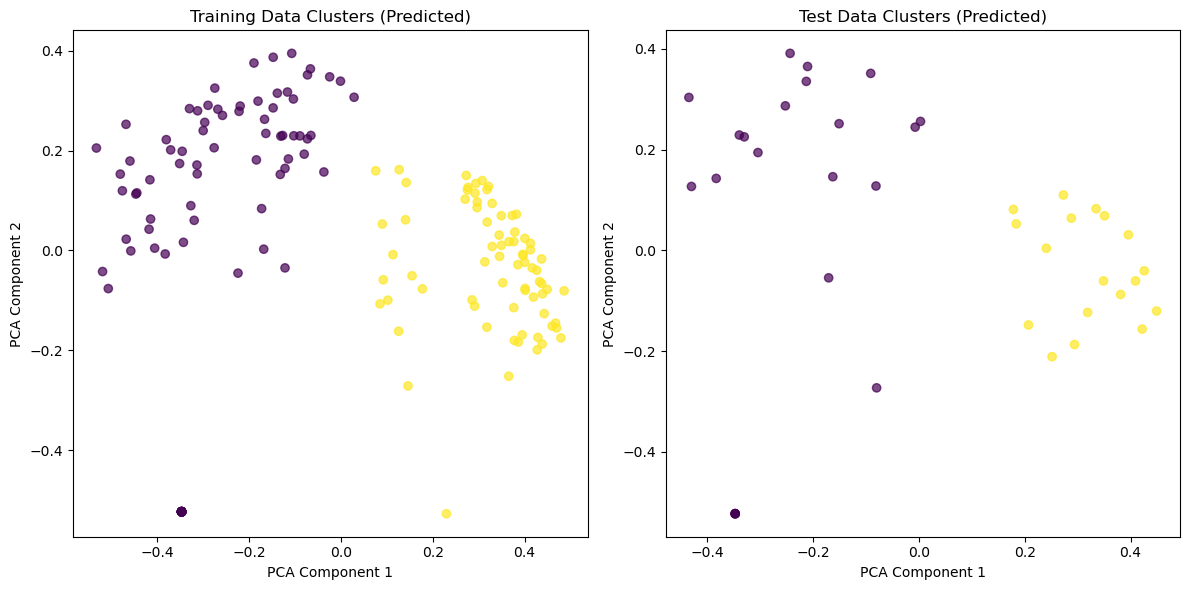

In [64]:
plt.figure(figsize=(12, 6))

# Training data clusters
plt.subplot(1, 2, 1)
plt.scatter(X_train_rdf_pca[:, 0], X_train_rdf_pca[:, 1], c=train_predicted_rdf_labels, cmap='viridis', alpha=0.7)
plt.title('Training Data Clusters (Predicted)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# Test data clusters
plt.subplot(1, 2, 2)
plt.scatter(X_test_rdf_pca[:, 0], X_test_rdf_pca[:, 1], c=test_predicted_rdf_labels, cmap='viridis', alpha=0.7)
plt.title('Test Data Clusters (Predicted)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.tight_layout()
plt.show()

In [65]:
#training set metrics
print("Training Set Metrics:")
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_train_rdf, train_predicted_rdf_labels))
print("Completeness: %0.3f" % metrics.completeness_score(y_train_rdf, train_predicted_rdf_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y_train_rdf, train_predicted_rdf_labels))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(y_train_rdf, train_predicted_rdf_labels))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_train_rdf_vectors, train_predicted_rdf_labels))

print("\nTest Set Metrics:")
#test set metrics
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_test_rdf, test_predicted_rdf_labels))
print("Completeness: %0.3f" % metrics.completeness_score(y_test_rdf, test_predicted_rdf_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y_test_rdf, test_predicted_rdf_labels))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(y_test_rdf, test_predicted_rdf_labels))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_test_rdf_vectors, test_predicted_rdf_labels))

Training Set Metrics:
Homogeneity: 0.626
Completeness: 0.630
V-measure: 0.628
Adjusted Rand-Index: 0.721
Silhouette Coefficient: 0.200

Test Set Metrics:
Homogeneity: 0.683
Completeness: 0.687
V-measure: 0.685
Adjusted Rand-Index: 0.715
Silhouette Coefficient: 0.175


## PART 2 : Comparing  Linguistic Processing Libraries
## II.1 Named Entity Recognition

In [66]:
#spacy english model should already be downloaded/imported


def read_files(directory_path):
    """Function to read the contents of each .txt file in a directory into a list

    Args:
        directory_path (str) : File path of the directory where .txt files are stored 

    Returns:
        List[str]: A list of the contents of .txt files.
     
       """
    chef_texts = []
    astro_texts = []
    # List all files in the given directory that end with .txt
    for filename in os.listdir(directory_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(directory_path, filename)
            # Open each file and read the contents
            if '_Chefs' in filename : 
                with open(file_path, 'r', encoding='utf-8') as file:
                    print(filename)    
                    chef_contents = file.read()
                    chef_texts.append(chef_contents)
            else : 
                if '_Astronauts' in filename : 
                    with open(file_path, 'r', encoding='utf-8') as file:
                        print(filename)    
                        astro_contents = file.read()
                        astro_texts.append(astro_contents)

                    
    return chef_texts , astro_texts

In [68]:
path = 'output'
# Call the function and save the results to variables
chef_texts, astro_texts = read_files(path)

# Print the number of texts read
print(f"Number of astronaut texts: {len(astro_texts)}")
print(f"Number of chef texts: {len(chef_texts)}")

Roy_Yamaguchi_Chefs.txt
Sat_Bains_Chefs.txt
Anne_Kearney_Chefs.txt
Melissa_d_Arabian_Chefs.txt
Joseph_P__Kerwin_Astronauts.txt
David_Ruggerio_Chefs.txt
Josh_Emett_Chefs.txt
Sandra_Magnus_Astronauts.txt
Renate_Brümmer_Astronauts.txt
Pyotr_Dubrov_Astronauts.txt
Paul_Scully_Power_Astronauts.txt
Belinda_Leong_Chefs.txt
Rochelle_Adonis_Chefs.txt
David_Scott_Astronauts.txt
David_Rocco_Chefs.txt
Bradley_Ogden_Chefs.txt
Bernard_A__Harris_Jr__Astronauts.txt
Roman_Romanenko_Astronauts.txt
Patrick_O_Connell__chef__Chefs.txt
Homaro_Cantu_Chefs.txt
Bill_Granger_Chefs.txt
Pavel_Vinogradov_Astronauts.txt
David_M__Walker__astronaut__Astronauts.txt
Roberta_Bondar_Astronauts.txt
Benny_the_Chef_Chefs.txt
Omar_Allibhoy_Chefs.txt
Samin_Nosrat_Chefs.txt
Sam_Kim__chef__Chefs.txt
David_Chang_Chefs.txt
Sarah_Kramer_Chefs.txt
Betty_Groff_Chefs.txt
Morgan_Murphy__food_critic__Chefs.txt
David_M__Brown_Astronauts.txt
Roger_K__Crouch_Astronauts.txt
Ronald_J__Garan_Jr__Astronauts.txt
Holger_Stromberg_Chefs.txt
Josep

In [69]:
print(astro_texts)

[' Joseph Peter Kerwin (born February 19, 1932) is an American physician and former NASA astronaut.[1] He served as the science pilot for the Skylab 2 mission from May 25, 1973, to June 22, 1973. He was the first physician to be selected for astronaut training and the first doctor from the United States to enter space.[2][3] Kerwin was the one who uttered the words during Apollo 13: "Farewell, Aquarius, and we thank you."[4] He was inducted into the United States Astronaut Hall of Fame in 1997.', 'Sandra Hall Magnus (born October 30, 1964) is an American engineer and a former NASA astronaut.[2] She returned to Earth with the crew of STS-119 Discovery on March 28, 2009, after having spent 134 days in orbit.[3] She was assigned to the crew of STS-135, the final mission of the Space Shuttle. She is also a licensed amateur radio operator with the call sign KE5FYE. From 2012 until 2018 Magnus was the executive director of the American Institute of Aeronautics and Astronautics. Magnus was bo

In [70]:
# Load SpaCy English model
spacy_nlp = spacy.load("en_core_web_sm")
# Initialize Stanza pipeline for English NER, without tokenization
stanza.download('en')
stanza_nlp = stanza.Pipeline(lang='en', processors='tokenize,ner', tokenize_pretokenized=True)


2024-06-15 23:32:29 INFO: Downloaded file to /Users/asadl/stanza_resources/resources.json
2024-06-15 23:32:29 INFO: Downloading default packages for language: en (English) ...
2024-06-15 23:32:31 INFO: File exists: /Users/asadl/stanza_resources/en/default.zip
2024-06-15 23:32:34 INFO: Finished downloading models and saved to /Users/asadl/stanza_resources
2024-06-15 23:32:34 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-06-15 23:32:34 INFO: Downloaded file to /Users/asadl/stanza_resources/resources.json
2024-06-15 23:32:35 INFO: Loading these models for language: en (English):
| Processor | Package                   |
-----------------------------------------
| tokenize  | combined                  |
| ner       | ontonotes-ww-multi_charlm |

2024-06-15 23:32:35 INFO: Using device: cpu
2024-06-15 23:32:35 INFO: Loading: tokenize
2024-06-15 23:32:35 INFO: Loading: ner
2024-06-15 23:32:36 INFO: Done loading processors!


In [71]:
#STANZA NER BUT FIRST USING SPACY TOKENIZER

def align_tokens_with_stanza(text):
    """Uses SpaCy for tokenization and Stanza for NER on the tokenized input.
    
    Args:
        texts (list of str): List of document texts.

    Returns:
        list of lists: Each sublist contains tuples (entity_text, entity_type) for each document.
    """
    st_ner_results = []
    
        # Tokenize with SpaCy
        
    spacy_doc = spacy_nlp(text)
        # Rebuild text from tokens suitable for Stanza
    sp_tokens = [[token.text for token in sent] for sent in spacy_doc.sents]
        # Creating a document compatible with Stanza NER from SpaCy tokens
        # Process with Stanza NER
    processed_doc = stanza_nlp(sp_tokens)
    entities = [(ent.text, ent.type) for ent in processed_doc.ents]
    
    return entities

In [72]:
#SPACY NER 

def get_spacy_ner(text):
    """Process a list of documents and return a list of lists of named entities for each document.
    
    Args:
        texts (list of str): A list containing the text of each document.

    Returns:
        list of lists: A list where each item is a list of tuples (entity_text, entity_type) for each document.
    """
    doc = spacy_nlp(text)
    entities = []
    for ent in doc.ents:
        entities.append((ent.text, ent.label_))
        
    return entities

In [73]:
#PUTTING RESULTS INTO A DATAFRAME

# Taking relevant info from biographies_df in part 1 and adding in columns for spacy and stanza NER results 
#This cell can take between 10-15 mins to run 

ner_df = biographies_df[['Biography', 'Person_Name', 'Category']].copy()
ner_df['Spacy_NER'] = ner_df['Biography'].apply(get_spacy_ner)
ner_df['Stanza_NER'] = ner_df['Biography'].apply(align_tokens_with_stanza)

In [74]:
ner_df.head()

,Biography,Person_Name,Category,Spacy_NER,Stanza_NER
0,Cai Xuzhe (Chinese: 蔡旭哲; born May 1976)[2] is...,Cai Xuzhe,Astronauts,"[(Cai Xuzhe, PERSON), (Chinese, NORP), (May 19...","[(Cai Xuzhe, PERSON), (Chinese, NORP), (May 19..."
1,Carl Erwin Walz (born 6 September 1955) is a ...,Carl E. Walz,Astronauts,"[(Carl Erwin Walz, PERSON), (6 September 1955,...","[(Carl Erwin Walz, PERSON), (6 September 1955,..."
2,"Carl Joseph Meade (born November 16, 1950) is ...",Carl J. Meade,Astronauts,"[(Carl Joseph Meade, PERSON), (November 16, 19...","[(Carl Joseph Meade, PERSON), (November 16 , 1..."
3,Carlos Ismael Noriega (born 8 October 1959) i...,Carlos I. Noriega,Astronauts,"[(Carlos Ismael Noriega, PERSON), (8 October 1...","[(Carlos Ismael Noriega, PERSON), (8 October 1..."
4,Pyotr Valerievich Dubrov (Russian: Пётр Валерь...,Pyotr Dubrov,Astronauts,"[(Pyotr Valerievich Dubrov, PERSON), (Russian,...","[(Pyotr Valerievich Dubrov, PERSON), (Russian,..."


In [75]:
#Saves the dataframe as .csv file to the folder you are working in 
ner_df.to_csv('NER_Categorized_Results.csv', index=False)

In [76]:
# STATISTICAL ANALYSIS PART - FIRST NEED TO LOAD CSV FILE

results_df = pd.read_csv('NER_Categorized_Results.csv')

In [77]:
#Converting the lists that have been 'stringified' in the dataframe back to python lists using ast
results_df['Spacy_NER'] = results_df['Spacy_NER'].apply(ast.literal_eval)
results_df['Stanza_NER'] = results_df['Stanza_NER'].apply(ast.literal_eval)

In [78]:
#function to calculate NE stats : 

def calculate_ne_stats(df, column):
    """
    Calculates statistics for the number of named entities (NEs) in a specified column of a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing named entity data.
        column (str): The column name in the DataFrame containing the named entities as lists.

    Returns:
        pd.DataFrame: A DataFrame containing the mean, minimum, and maximum count of named entities per category.
    """
    
    df[f'{column}_Count'] = df[column].apply(len)
    # Group by category and calculate mean, min, and max
    stats = df.groupby('Category')[f'{column}_Count'].agg(['mean', 'min', 'max'])
    return stats

In [79]:
spacy_stats = calculate_ne_stats(results_df, 'Spacy_NER')
stanza_stats = calculate_ne_stats(results_df, 'Stanza_NER')

print("SpaCy Named Entities Stats:")
print(spacy_stats)
print("\nStanza Named Entities Stats:")
print(stanza_stats)

SpaCy Named Entities Stats:
             mean  min  max
Category                   
Astronauts  25.21    5   67
Chefs       26.59    7   71

Stanza Named Entities Stats:
             mean  min  max
Category                   
Astronauts  26.16    5   62
Chefs       27.88    7   79


In [80]:
#calculate the average, minimum, and maximum number of words in each NE, grouped by category and package.

def ne_words_stats(df, column):
    """
    Calculates statistics on the number of words per named entity in a specified column of a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing named entity data.
        column (str): The column name in the DataFrame containing the named entities as lists of tuples.

    Returns:
        pd.DataFrame: A DataFrame with the mean, minimum, and maximum number of words per named entity for each category.
    """
    # Calculate the number of words in each named entity
    df[f'{column}_Words'] = df[column].apply(lambda ents: [len(ent[0].split()) for ent in ents])
    # Flatten the list of lists and then calculate mean, min, and max for each category
    words_stats = df.explode(f'{column}_Words').groupby('Category')[f'{column}_Words'].agg(['mean', 'min', 'max']).astype(float)
    return words_stats

spacy_words_stats = ne_words_stats(results_df, 'Spacy_NER')
stanza_words_stats = ne_words_stats(results_df, 'Stanza_NER')

print("SpaCy Words Stats:")
print(spacy_words_stats)
print("\nStanza Words Stats:")
print(stanza_words_stats)

SpaCy Words Stats:
                mean  min   max
Category                       
Astronauts  1.963903  1.0  13.0
Chefs       1.759684  1.0   9.0

Stanza Words Stats:
                mean  min   max
Category                       
Astronauts  2.183869  1.0  23.0
Chefs       1.973099  1.0  20.0


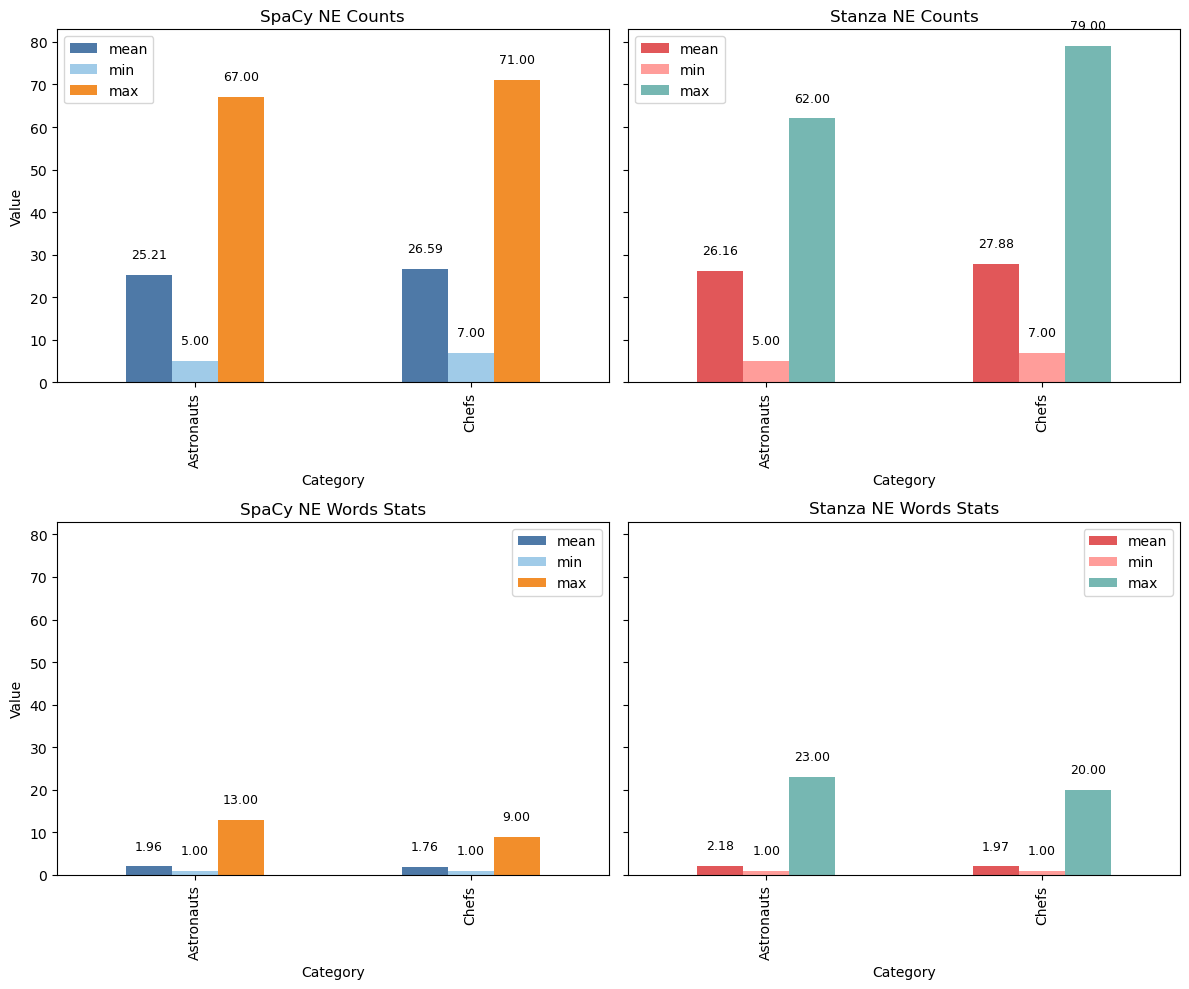

In [83]:
# VISUALIZATION 

# Assuming spacy_stats, stanza_stats, spacy_words_stats, and stanza_words_stats are defined
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10), sharey=True)

# Define color palettes
spacy_colors = ['#4e79a7', '#a0cbe8', '#f28e2b', '#ffbe7d', '#59a14f']  # Example blue shades
stanza_colors = ['#e15759', '#ff9d9a', '#76b7b2', '#ff9da7', '#edc948']  # Example red shades

# Plotting with annotations
def plot_with_annotations(ax, data, title, colors):
    """
    Plots a bar chart with annotations on each bar.

    Args:
        ax (matplotlib.axes.Axes): The matplotlib axes to plot on.
        data (pd.DataFrame or pd.Series): The data to plot as a bar chart.
        title (str): The title for the plot.
        colors (str or list): The colors to use for the bars.

    Returns:
        None
    """
    bars = data.plot.bar(ax=ax, title=title, color=colors)
    ax.set_xlabel('Category')
    ax.set_ylabel('Value')
    # Annotate each bar
    for bar in bars.patches:
        ax.annotate(f'{bar.get_height():.2f}',  # Format the value to 2 decimal places
                    (bar.get_x() + bar.get_width() / 2, bar.get_height()),  # Position
                    ha='center', va='bottom',  # Center the text horizontally and align it from below
                    textcoords="offset points",  # Interpret xytext as an offset in points
                    xytext=(0, 10),  # Move the text up by 10 points
                    fontsize=9)

# Apply the function to each subplot
plot_with_annotations(axs[0, 0], spacy_stats, 'SpaCy NE Counts', spacy_colors)
plot_with_annotations(axs[0, 1], stanza_stats, 'Stanza NE Counts', stanza_colors)
plot_with_annotations(axs[1, 0], spacy_words_stats, 'SpaCy NE Words Stats', spacy_colors)
plot_with_annotations(axs[1, 1], stanza_words_stats, 'Stanza NE Words Stats', stanza_colors)

plt.tight_layout()
plt.show()




#Check how to label bars with values to make it more legible 

## II.2 NER Analysis by Entity Type

In [82]:
def ner_analysis(spacy_ner, stanza_ner):
    """
    Analyze and compare named entity recognition (NER) results from SpaCy and Stanza.

    Args:
        spacy_ner (List[Tuple[str, str]]): List of named entities from SpaCy, each as a tuple (entity, type).
        stanza_ner (List[Tuple[str, str]]): List of named entities from Stanza, each as a tuple (entity, type).

    Returns:
        Tuple[int, int, int, int, int, int]: A tuple containing:
            - Full agreement count (exact match of entity and type)
            - Partial agreement count (entity matches, type can be different)
            - Exclusive to SpaCy count (entities found only by SpaCy)
            - Exclusive to Stanza count (entities found only by Stanza)
            - Type agreement in full overlaps count
            - Type agreement in partial overlaps count
    """
    spacy_set = set(spacy_ner)
    stanza_set = set(stanza_ner)

    # Calculate full agreement (exact text match and type match)
    full_agreement = spacy_set & stanza_set

    # Calculate partial agreement (exact text match, type can be different)
    partial_agreement = {entity for entity in spacy_set if any(entity[0] == stanza_entity[0] for stanza_entity in stanza_set)}

    # Calculate exclusive entities
    spacy_only = spacy_set - stanza_set
    stanza_only = stanza_set - spacy_set

    # Calculate type agreement full (exact match within fully agreed entities)
    type_agreement_full = {
        entity for entity in full_agreement
        if entity[1] == next(stanza_entity[1] for stanza_entity in stanza_set if stanza_entity[0] == entity[0])
    }

    # Calculate type agreement partial (same entity text but different type)
    type_agreement_partial = {
        entity for entity in partial_agreement
        if entity not in type_agreement_full and any(entity[0] == stanza_entity[0] and entity[1] != stanza_entity[1] for stanza_entity in stanza_set)
    }

    return (
        len(full_agreement),
        len(partial_agreement),
        len(spacy_only),
        len(stanza_only),
        len(type_agreement_full),
        len(type_agreement_partial)
    )


In [84]:
#Dataframe containing the NER results
results_df = pd.read_csv('NER_Categorized_Results.csv')

# Ensure 'Spacy_NER' and 'Stanza_NER' columns are correctly parsed as lists of tuples
results_df['Spacy_NER'] = results_df['Spacy_NER'].apply(ast.literal_eval)
results_df['Stanza_NER'] = results_df['Stanza_NER'].apply(ast.literal_eval)

# Apply ner_analysis function row-wise to calculate the counts
results_df['Full_Agreement'], results_df['Partial_Agreement'], results_df['Spacy_Only'], \
results_df['Stanza_Only'], results_df['Type_Agreement_Full'], results_df['Type_Agreement_Partial'] = \
zip(*results_df.apply(lambda row: ner_analysis(row['Spacy_NER'], row['Stanza_NER']), axis=1))

# Print the results
print(results_df)


                                             Biography        Person_Name  \
0     Cai Xuzhe (Chinese: 蔡旭哲; born May 1976)[2] is...          Cai Xuzhe   
1     Carl Erwin Walz (born 6 September 1955) is a ...       Carl E. Walz   
2    Carl Joseph Meade (born November 16, 1950) is ...      Carl J. Meade   
3     Carlos Ismael Noriega (born 8 October 1959) i...  Carlos I. Noriega   
4    Pyotr Valerievich Dubrov (Russian: Пётр Валерь...       Pyotr Dubrov   
..                                                 ...                ...   
195   Juliet Corson (January 14, 1841 – June 18, 18...      Juliet Corson   
196  Beverly Kim is a James Beard Award-winning che...        Beverly Kim   
197  Patrick O'Connell (born October 9, 1945) is an...  Patrick O'Connell   
198   Paul Ainsworth (born 1979) is an English chef...     Paul Ainsworth   
199  Paul Bartolotta (born June 8, 1961) is an Amer...    Paul Bartolotta   

       Category                                          Spacy_NER  \
0    

In [85]:
#calculate the results for astronauts
astro_subframe = results_df[results_df['Category'] == 'Astronauts']
a_full = astro_subframe['Full_Agreement'].values.sum()
a_partial = astro_subframe['Partial_Agreement'].values.sum()
a_sp_unique = astro_subframe['Spacy_Only'].values.sum()
a_st_unique = astro_subframe['Stanza_Only'].values.sum()
a_type_full = astro_subframe['Type_Agreement_Full'].values.sum()
a_type_partial = astro_subframe['Type_Agreement_Partial'].values.sum()
a_total_ne = a_full + a_partial + a_sp_unique + a_st_unique

#print results
print(a_full, a_partial, a_sp_unique, a_st_unique, a_type_full, a_type_partial, a_total_ne)

1461 1686 781 869 1453 233 4797


In [86]:
#calculate the sum for chefs
chef_subframe = results_df[results_df['Category'] == 'Chefs']
c_full = chef_subframe['Full_Agreement'].values.sum()
c_partial = chef_subframe['Partial_Agreement'].values.sum()
c_sp_unique = chef_subframe['Spacy_Only'].values.sum()
c_st_unique = chef_subframe['Stanza_Only'].values.sum()
c_type_full = chef_subframe['Type_Agreement_Full'].values.sum()
c_type_partial = chef_subframe['Type_Agreement_Partial'].values.sum()
c_total_ne = c_full + c_partial + c_sp_unique + c_st_unique

#print results
print(c_full, c_partial, c_sp_unique, c_st_unique, c_type_full, c_type_partial, c_total_ne)

1467 1797 834 935 1454 343 5033


In [87]:
 # Print final results  for chefs
print(f"\nNER Agreement Statistics for Chefs:")
print(f"  Total Named Entities: {c_total_ne}")
print(f"  Complete Overlap: {c_full}")
print(f"  Partial Overlap: {c_partial}")
print(f"  Exclusive to SpaCy: {c_sp_unique}")
print(f"  Exclusive to Stanza: {c_st_unique}")
print(f"  Type Agreement in Complete Overlaps: {c_type_full}")
print(f"  Type Agreement in Partial Overlaps: {c_type_partial}")


NER Agreement Statistics for Chefs:
  Total Named Entities: 5033
  Complete Overlap: 1467
  Partial Overlap: 1797
  Exclusive to SpaCy: 834
  Exclusive to Stanza: 935
  Type Agreement in Complete Overlaps: 1454
  Type Agreement in Partial Overlaps: 343


In [88]:
 # Print final results for astronauts
print(f"\nNER Agreement Statistics for Astronauts:")
print(f"  Total Named Entities: {a_total_ne}")
print(f"  Complete Overlap: {a_full}")
print(f"  Partial Overlap: {a_partial}")
print(f"  Exclusive to SpaCy: {a_sp_unique}")
print(f"  Exclusive to Stanza: {a_st_unique}")
print(f"  Type Agreement in Complete Overlaps: {a_type_full}")
print(f"  Type Agreement in Partial Overlaps: {a_type_partial}")


NER Agreement Statistics for Astronauts:
  Total Named Entities: 4797
  Complete Overlap: 1461
  Partial Overlap: 1686
  Exclusive to SpaCy: 781
  Exclusive to Stanza: 869
  Type Agreement in Complete Overlaps: 1453
  Type Agreement in Partial Overlaps: 233


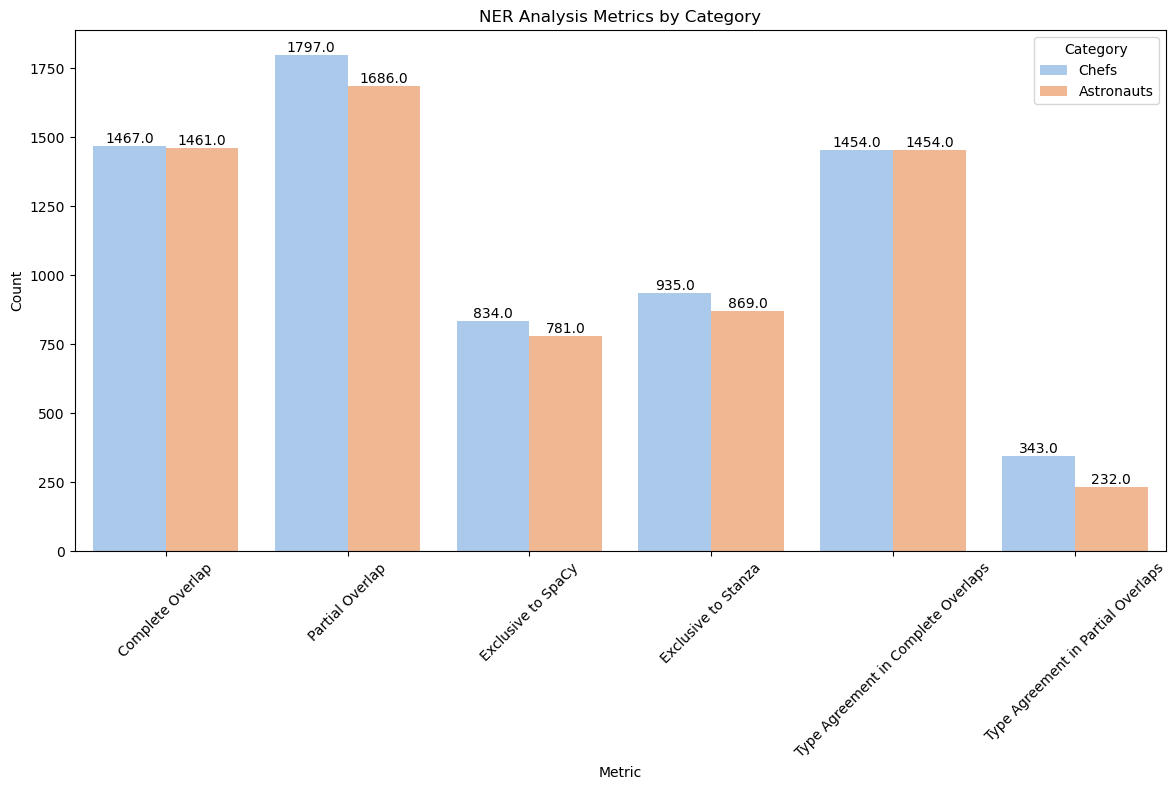

In [89]:
#NER agreement statistics for Chefs and Astronauts
chefs_stats = {

    'Complete Overlap': 1467,
    'Partial Overlap': 1797,
    'Exclusive to SpaCy': 834,
    'Exclusive to Stanza': 935,
    'Type Agreement in Complete Overlaps': 1454,
    'Type Agreement in Partial Overlaps': 343
}

astronauts_stats = {

    'Complete Overlap': 1461,
    'Partial Overlap': 1686,
    'Exclusive to SpaCy': 781,
    'Exclusive to Stanza': 869,
    'Type Agreement in Complete Overlaps': 1454,
    'Type Agreement in Partial Overlaps': 232
}

# Convert dictionaries to DataFrames
chefs_df = pd.DataFrame(chefs_stats.items(), columns=['Metric', 'Count'])
chefs_df['Category'] = 'Chefs'

astronauts_df = pd.DataFrame(astronauts_stats.items(), columns=['Metric', 'Count'])
astronauts_df['Category'] = 'Astronauts'

# Concatenate DataFrames
combined_df = pd.concat([chefs_df, astronauts_df], ignore_index=True)

plt.figure(figsize=(12, 8))
ax = sns.barplot(data=combined_df, x='Metric', y='Count', hue='Category', palette='pastel', errcolor='black', errwidth=0)

plt.title('NER Analysis Metrics by Category')
plt.xlabel('Metric')
plt.ylabel('Count')
plt.legend(title='Category')
plt.xticks(rotation=45)


for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height}", (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()


## II.3 NER Verification against Knowledge Graphs

In [93]:
# Load KG data from JSON files
with open('output/Astronauts_kg_facts.json', 'r') as f:
    astronaut_kg_facts = json.load(f)

with open('output/Chefs_kg_facts.json', 'r') as f:
    chef_kg_facts = json.load(f)

# Load NER results DataFrame
df = pd.read_csv('NER_Categorized_Results.csv')
df['Spacy_NER'] = df['Spacy_NER'].apply(ast.literal_eval)
df['Stanza_NER'] = df['Stanza_NER'].apply(ast.literal_eval)

In [94]:
def fuzzy_match_entity(entity, kg_facts):
    """
    Perform a fuzzy match of an entity in the knowledge graph (KG) facts.

    Args:
        entity (str): The entity to match.
        kg_facts (list): The list of KG facts for a person.

    Returns:
        bool: True if a match is found, False otherwise.
    """
    # Escape entity for regex to handle special characters
    escaped_entity = re.escape(entity)
    for fact in kg_facts:
        for key, value in fact.items():
            # Create a regex pattern to match the entity in the KG value
            if re.search(rf'\b{escaped_entity}\b', value, re.IGNORECASE):
                return True
    return False

In [95]:
def process_ner_entities(ner_entities, kg_facts):
    """
    Process a list of NER entities and match them against KG facts.

    Args:
        ner_entities (list): The list of NER entities.
        kg_facts (list): The KG facts for a person.

    Returns:
        tuple: (matched_entities, match_ratio)
    """
    matched_entities = []
    total_entities = len(ner_entities)
    
    for entity in ner_entities:
        if fuzzy_match_entity(entity, kg_facts):
            matched_entities.append(entity)
    
    match_ratio = len(matched_entities) / total_entities if total_entities else 0
    return matched_entities, match_ratio

In [98]:
# Initialize results storage
comparison_results = defaultdict(lambda: defaultdict(list))

for index, row in df.iterrows():
    person_name = row['Person_Name']
    category = row['Category']
    spacy_ner = [ent[0] for ent in row['Spacy_NER']]
    stanza_ner = [ent[0] for ent in row['Stanza_NER']]

    # Load corresponding KG data
    kg_facts = []
    if category == 'Astronauts':
        kg_facts = astronaut_kg_facts.get(person_name, [])
    elif category == 'Chefs':
        kg_facts = chef_kg_facts.get(person_name, [])

    # Process NER entities against KG
    spacy_found, spacy_ratio = process_ner_entities(spacy_ner, kg_facts)
    stanza_found, stanza_ratio = process_ner_entities(stanza_ner, kg_facts)

    # Store results
    comparison_results[category]['spacy_total'].append(len(spacy_ner))
    comparison_results[category]['spacy_found'].append(len(spacy_found))
    comparison_results[category]['spacy_ratio'].append(spacy_ratio)

    comparison_results[category]['stanza_total'].append(len(stanza_ner))
    comparison_results[category]['stanza_found'].append(len(stanza_found))
    comparison_results[category]['stanza_ratio'].append(stanza_ratio)

# Aggregate and print results
for category, stats in comparison_results.items():
    spacy_total_ne = sum(stats['spacy_total'])
    spacy_matched_ne = sum(stats['spacy_found'])
    spacy_avg_ratio = sum(stats['spacy_ratio']) / len(stats['spacy_ratio'])

    stanza_total_ne = sum(stats['stanza_total'])
    stanza_matched_ne = sum(stats['stanza_found'])
    stanza_avg_ratio = sum(stats['stanza_ratio']) / len(stats['stanza_ratio'])

    print(f"\nNER Verification Statistics for {category}:")
    print(f"  SpaCy Total NEs: {spacy_total_ne}")
    print(f"  SpaCy Matched NEs: {spacy_matched_ne}")
    print(f"  SpaCy Match Ratio: {spacy_avg_ratio:.2f}")

    print(f"  Stanza Total NEs: {stanza_total_ne}")
    print(f"  Stanza Matched NEs: {stanza_matched_ne}")
    print(f"  Stanza Match Ratio: {stanza_avg_ratio:.2f}")


NER Verification Statistics for Astronauts:
  SpaCy Total NEs: 2521
  SpaCy Matched NEs: 1539
  SpaCy Match Ratio: 0.65
  Stanza Total NEs: 2616
  Stanza Matched NEs: 1443
  Stanza Match Ratio: 0.57

NER Verification Statistics for Chefs:
  SpaCy Total NEs: 2659
  SpaCy Matched NEs: 1438
  SpaCy Match Ratio: 0.55
  Stanza Total NEs: 2788
  Stanza Matched NEs: 1381
  Stanza Match Ratio: 0.50
